In [1]:
from pandas import read_csv, Series
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
from pickle import load
from glove import Glove
import adagram
from gensim.models.wrappers import FastText, Wordrank
from embed_utils import Word2VecF, Swivel, cosine_sim, get_adagram_sense_prob, wv
from utils.string_utils import *

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.dummy import DummyClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import (accuracy_score, brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [3]:
import matplotlib.pyplot as plt
import seaborn

In [12]:
old_err_state = np.seterr(all='raise')

def vectorize_message(sentence, model, num_features, vocab):
    featureVec = np.zeros((num_features), dtype='float32')
    nwords = 0
    
    tokens = make_tokens(sentence.lower(), vocab)

    for word in tokens:
        if word in vocab: 
            if model == 'word2vec':
                featureVec = np.add(featureVec, word2vec[word])
            elif model == 'wang2vec':
                featureVec = np.add(featureVec, wang2vec[word])
            elif model == 'glove':
                featureVec = np.add(featureVec, wv(glove, word))
            elif model == 'word2vecf':
                featureVec = np.add(featureVec, w2vf.word2vec(word))
            elif model == 'adagram':
                featureVec = np.add(featureVec, ada_model.sense_vector(word, get_adagram_sense_prob(ada_model, word)))
            elif model == 'fasttext':
                featureVec = np.add(featureVec, ft[word])
            elif model == 'bow':
                featureVec = np.add(featureVec, bow[word])
            elif model == 'swivel':
                featureVec = np.add(featureVec, swivel.lookup(word))
            nwords = nwords + 1
    try:
        featureVec = np.divide(featureVec, nwords)
    except FloatingPointError:
         featureVec = np.zeros((num_features), dtype='float32')
    return featureVec

In [14]:
df = read_csv('2ch_test_set.csv')
df.text = df.text.apply(cut)
df.text = df.text.apply(morph_parse)

In [15]:
Y = df.is_relevent.values

Загрузка Word2Vec-модели

In [16]:
word2vec = Word2Vec.load('models/2ch_word2vec')
word2vec_vocab = word2vec.wv.vocab

word2vec = Word2Vec.load('models/2ch_word2vec_all_lem')
word2vec_vocab = word2vec.wv.vocab

Загрузка Glove-модели

In [18]:
with open('models/glove_2ch', 'rb') as fp:
    glove = load(fp)
glove_vocab = glove.dictionary

Загрузка Wang2Vec-модели

In [19]:
wang2vec = KeyedVectors.load_word2vec_format('models/wang2vec_2ch', binary=True)
wang2vec_vocab = wang2vec.vocab

Загрузка Word2Vec-f-модели

In [20]:
from os import path

w2vf = Word2VecF.load(path.join('models', 'w2vf.npy'), path.join('models', 'w2vf.vocab'))
w2vf_vocab = w2vf._vocab

Загрузка Adagram-модели

In [21]:
ada_model = adagram.VectorModel.load('models/adagram_model.pkl')
adagram_vocab = ada_model.dictionary.word2id.keys()

Загрузка BOW-модели

In [22]:
from pickle import load

with open('models/bow.pickle', 'rb') as fp:
    bow = load(fp)

Загрузка Swivel-модели

In [23]:
swivel = Swivel('models/swivel.txt', 'models/swivel.bin')
swivel_vocab = swivel.vocab

Загрузка Fasttext-модели

In [24]:
ft = FastText.load_word2vec_format('models/fasttext.vec')
ft_vocab = ft.vocab

Загрузка Wordrank-модели

In [ ]:
#wr = Wordrank()
#mod = Wordrank.load_wordrank_model('/media/defeater/d5233b78-d9c7-40e7-a454-8b108bcc4b8a/defeater/NLP/wordrank/meta/cooccurrence')
#wr = wr.train('/media/defeater/d5233b78-d9c7-40e7-a454-8b108bcc4b8a/defeater/NLP/wordrank', corpus_file='corpus.txt', out_path='/media/defeater/d5233b78-d9c7-40e7-a454-8b108bcc4b8a/defeater/NLP/wordrank')

Получение датасетов

In [26]:
word2vec_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    word2vec_vectors[i] = vectorize_message(m['text'], 'word2vec', 100, word2vec_vocab)

In [27]:
glove_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    glove_vectors[i] = vectorize_message(m['text'], 'glove', 100, glove_vocab)

In [28]:
wang2vec_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    wang2vec_vectors[i] = vectorize_message(m['text'], 'wang2vec', 100, wang2vec_vocab)

In [29]:
adagram_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    adagram_vectors[i] = vectorize_message(m['text'], 'adagram', 100, adagram_vocab)

In [30]:
w2vf_vectors = np.zeros(shape=(len(df),50), dtype='float32')

for i, m in df.iterrows():
    w2vf_vectors[i] = vectorize_message(m['text'], 'word2vecf', 50, w2vf_vocab)

In [31]:
ft_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    ft_vectors[i] = vectorize_message(m['text'], 'fasttext', 100, ft_vocab)

In [32]:
bow_vectors = np.zeros(shape=(len(df),1), dtype='float32')

for i, m in df.iterrows():
    bow_vectors[i] = vectorize_message(m['text'], 'bow', 1, bow)

In [33]:
swivel_vectors = np.zeros(shape=(len(df), 300), dtype='float32')

for i, m in df.iterrows():
    swivel_vectors[i] = vectorize_message(m['text'], 'swivel', 300, swivel_vocab)

Сравнение

In [34]:
def set_plt_params():
    title_font = {'size':'30', 'color':'black', 'weight':'normal',
                  'verticalalignment':'bottom'} 
    axis_font = {'size':'30'}

    plt.figure(figsize=(40, 20))
    plt.xlabel('Training examples', **axis_font)
    plt.ylabel('Score',  **axis_font)
    plt.tick_params(labelsize=30)

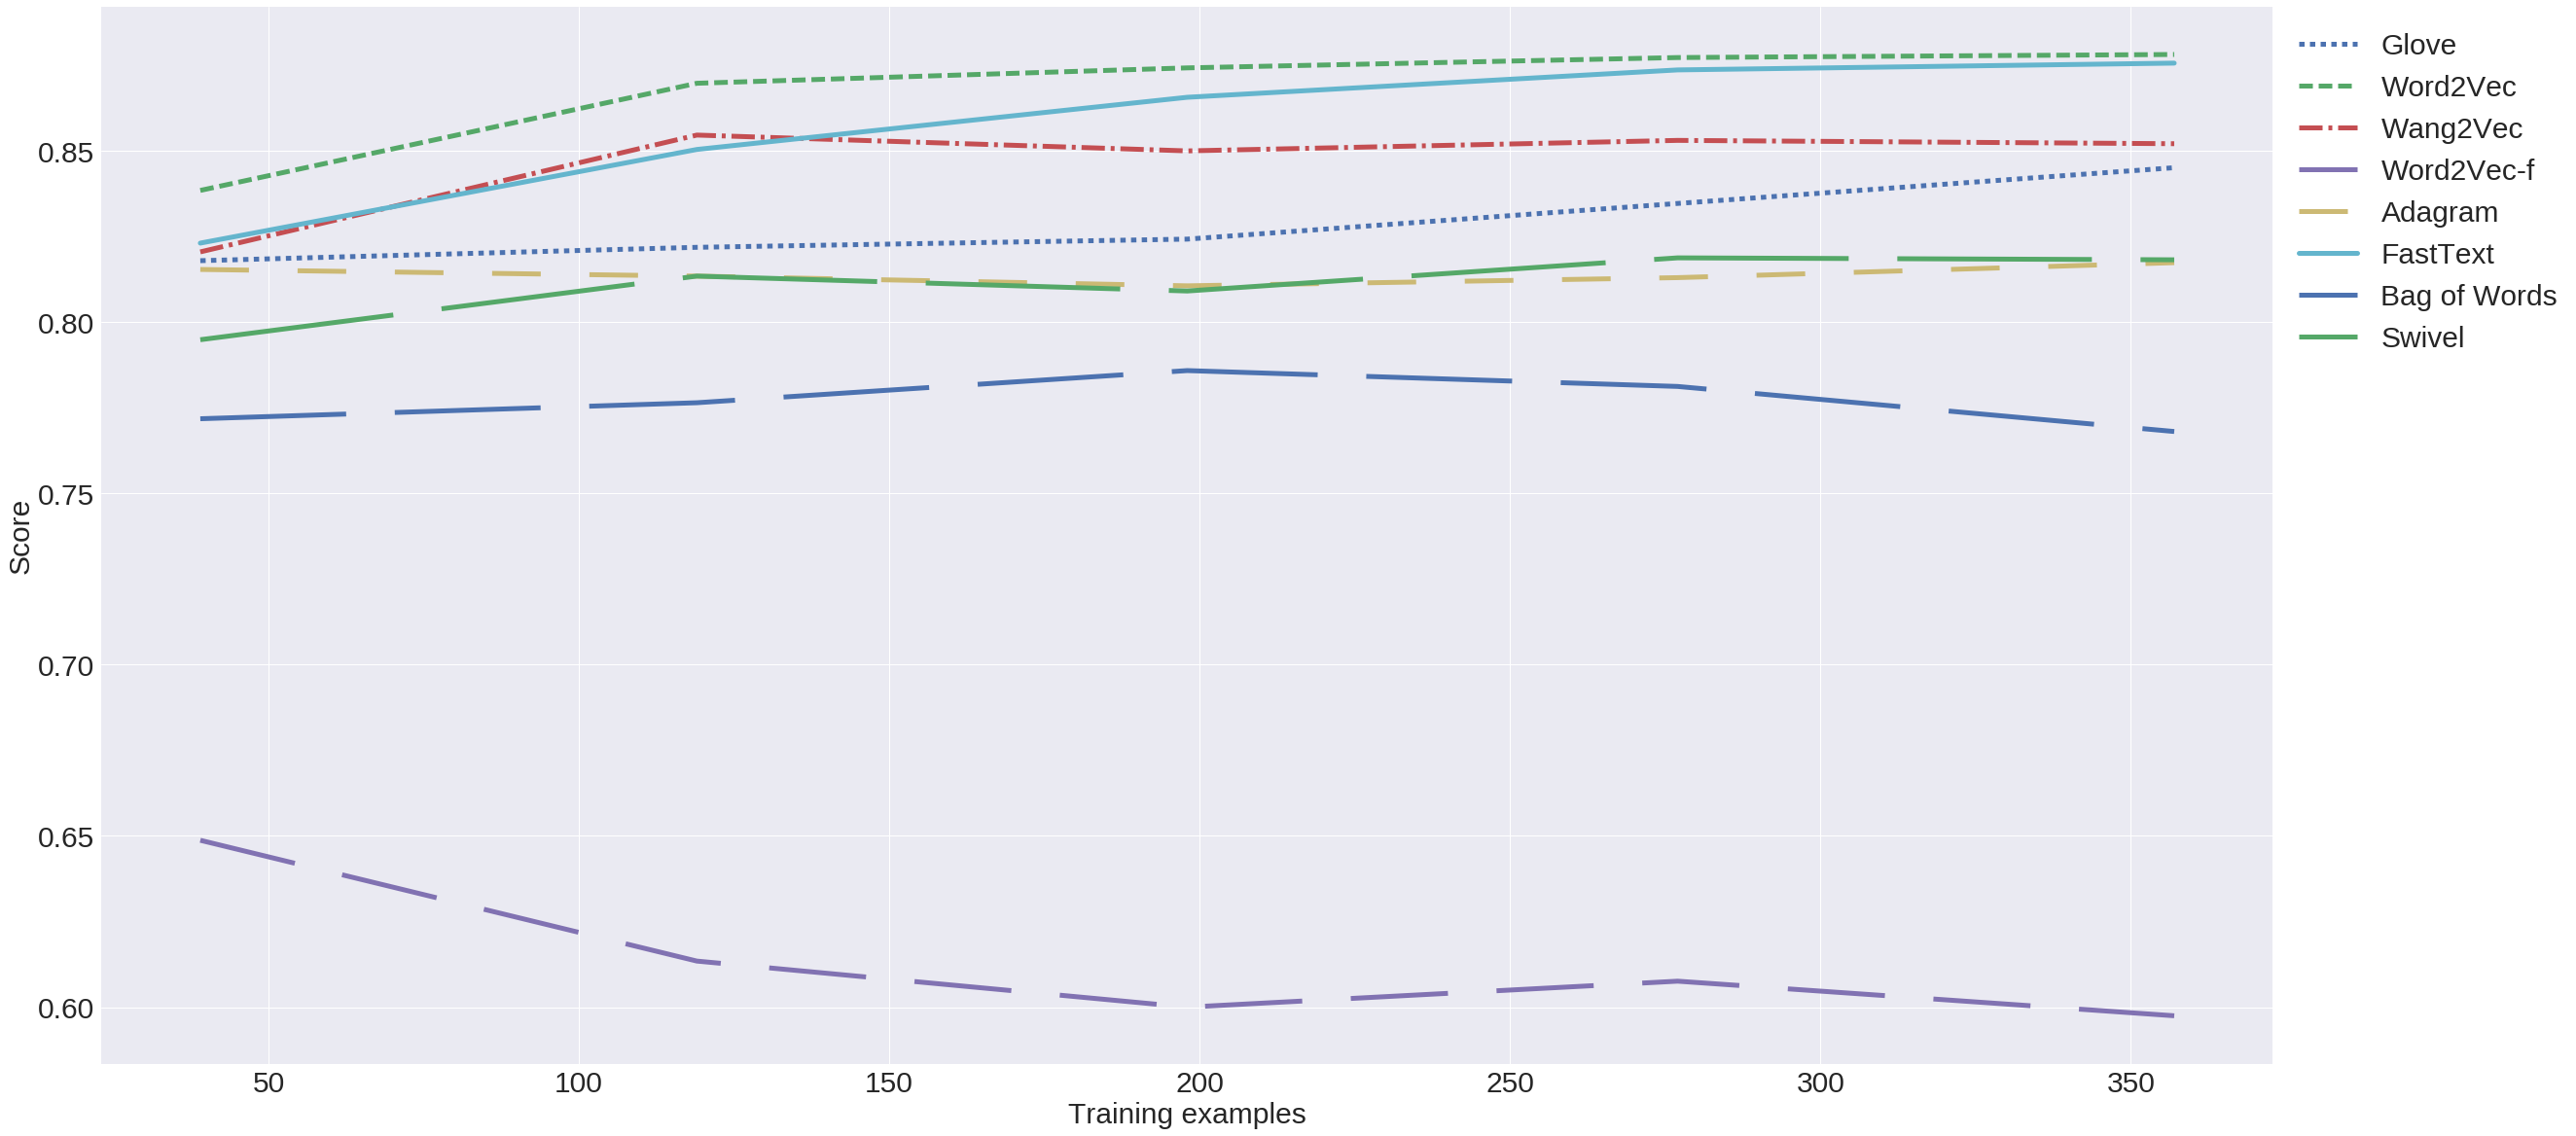

In [35]:
set_plt_params()

for X, name, lstyle in [(glove_vectors, 'Glove', 'dotted'),
                (word2vec_vectors, 'Word2Vec', 'dashed'),
                (wang2vec_vectors, 'Wang2Vec', 'dashdot'),
                (w2vf_vectors, 'Word2Vec-f',  (0, (20,10))),
                (adagram_vectors, 'Adagram', (0,(10,10))),
                (ft_vectors, 'FastText','solid'),
                (bow_vectors, 'Bag of Words',(0,(30,10))),
                (swivel_vectors, 'Swivel',(0,(40,10))),
                ]:
    #estimator = SVC(C = 0.01, kernel = 'linear')
    estimator = KNeighborsClassifier(n_neighbors = 3)
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
    train_sizes=np.linspace(0.1, 0.9, 5)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, Y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label=name, linewidth=5, linestyle=lstyle)

plt.legend(loc="upper left", bbox_to_anchor=(1,1), prop={'size':30})
#plt.savefig('classifiers.png', bbox_inches='tight')
plt.show()

In [49]:
# -*- coding: utf-8 -*-

from re import compile
from requests import get
from json import JSONDecodeError
from pandas import DataFrame, concat
from sys import exit

DVACH = 'https://2ch.hk/'


def remove_html(text):
    html = compile(r'<.*?>')
    return html.sub('', text)


def cut(text):
    r = compile(r'\(OP\)|&#(\d*);|&quot;|&gt;|&#47;|(http|https):.*')
    return r.sub('', make_alpha(remove_html(punctuate_sent(punctuate_word(text))))).lower().strip()


def make_alpha(text):
    alpha = compile('[^a-zа-яA-ZА-Я,\.\?! ]')
    return alpha.sub('', text)


def punctuate_sent(data):
    r = compile(r'([a-zA-Zа-яА-Я])([.!\?])')
    return r.sub(r'\1. ', data)


def punctuate_word(data):
    r = compile(r'([a-zA-Zа-яА-Я])([,])')
    return r.sub(r'\1, ', data)


def load_page(board='b'):
    try:
        dvach_page = get(DVACH + board + '/catalog.json').json()
        threads = [i['num'] for i in dvach_page['threads']]
    except:
        print('Такой доски нет. Попробуй ввести две буквы: vg')
        return None
    return threads


def get_thread_names(threads, board):
    return [get(DVACH + board + '/res/' + thread + '.json', timeout=100).json()['threads'][0]['posts'][0]['subject'] for
            thread in threads[:15]]


def show_thread_names(threads_names, start=0):
    for index, name in enumerate(threads_names[:15]):
        print(index, ' ', cut(name))


def get_annotate_data(board, thread):
    th = get(DVACH + board + '/res/' + thread + '.json', timeout=100).json()
    reference = cut(th['threads'][0]['posts'][0]['comment'])[:100].lower()
    comments = [cut(i['comment'])[:100] for i in th['threads'][0]['posts'][1:] if cut(i['comment'])[:100]]
    return reference, comments


def start_annotating(reference, comments):
    labels = []
    for i in comments:
        print('ОП-пост:')
        print(reference)
        print('Сообщение:')
        print(i)
        while (True):
            label = input()
            if label == 'quit':
                return labels
            try:
                label = int(label)
            except ValueError:
                print('Введи 1 если сообщения относятся к одной теме, и 0 иначе. quit для выхода (данные сохранятся)')
                continue
            if label == 1 or label == 0:
                label = int(label)
                break
            else:
                print('Введи 1 если сообщения относятся к одной теме, и 0 иначе. quit для выхода (данные сохранятся)')
        labels.append(int(label))
    return labels


def make_df(reference, comments, labels):
    df = DataFrame()
    df['comment'] = comments
    df['reference'] = reference
    df['labels'] = labels
    df.index.names = ['comment_id']
    try:
        file_path = 'annotated.csv'
        old_df = DataFrame.from_csv(file_path, encoding = 'cp1251')
        df = concat((df, old_df)).drop_duplicates(subset='comment').reset_index(drop=True)
    except FileNotFoundError:
        pass
    df.to_csv('annotated.csv', encoding = 'cp1251')

In [50]:
board = 'b'
threads = load_page(board)
_, com = get_annotate_data(board, threads[3])

In [51]:
com

['бамп',
 'op',
 'opпомойка ебаная,  тебе дали документы для фильмовпикчдокументов,  тебе дали удобный пускпанель для ',
 'я привык так.',
 'понятное дело что ты не изза эстетического удовольствия рабочий стол в такое превратил.',
 'opрейт',
 'какой пиздец.',
 'жирафов из .',
 'квип,  маил агент.  у тебя мать за пекарней сидит.',
 'op',
 'op',
 'так вот.  вс под рукой.',
 'охуел на квип гнать.  это ебаная классика.  ты предлагаешь вайбер или вотсапп использовать.  как мал',
 'когда у тебя под рукой не конкретные вещи,  а помойка с этими вещами,  это не есть хорошо.',
 'никогда не пользовался парашным квипом.  rampq дает пососать.',
 'когда ты эту quotпомойкуquot создашь сам,  последовательно,  то проблем с ориентировкой нет никаких.',
 'op',
 'красотень,  есть оригинал.',
 'какие преимущества.',
 'ты что недавно систему установил.',
 'дети против волшебников.  ты лоля.',
 'ниплоха',
 'месяца  назад',
 'причем тупая лоля',
 'это папка',
 'у тебя какието отклонения,  небось и стол свой п